In [1]:
using ResumableFunctions, StatsBase, Statistics
using FFTW, FITSIO, Intervals
using DocStringExtensions
using LinearAlgebra
using Random
using RecipesBase
using Test
using Distributions
include("events.jl")
include("lightcurve.jl")
include("gti.jl")
include("fourier.jl")
function merge_overlapping_gtis(gtis::Matrix{Float64})
    if size(gtis, 1) <= 1
        return gtis
    end

    # Sort by start time
    sort_indices = sortperm(view(gtis, :, 1))
    sorted_gtis = gtis[sort_indices, :]

    # Pre-allocate merged array
    merged = Matrix{Float64}(undef, size(gtis, 1), 2)
    merged_count = 0

    current_start = sorted_gtis[1, 1]
    current_stop = sorted_gtis[1, 2]

    for i in 2:size(sorted_gtis, 1)
        start_time = sorted_gtis[i, 1]
        stop_time = sorted_gtis[i, 2]

        # Check if intervals overlap or touch (with small tolerance)
        if start_time <= current_stop + 1e-6
            current_stop = max(current_stop, stop_time)
        else
            # No overlap, add current interval to merged
            merged_count += 1
            merged[merged_count, 1] = current_start
            merged[merged_count, 2] = current_stop
            current_start = start_time
            current_stop = stop_time
        end
    end

    # Add the final interval
    merged_count += 1
    merged[merged_count, 1] = current_start
    merged[merged_count, 2] = current_stop

    return merged[1:merged_count, :]
end

merge_overlapping_gtis (generic function with 1 method)

In [2]:
"""
Represents a power spectrum computed from time series data.

Fields:
- freq: Frequency bins
- power: Power values for each frequency
- power_err: Uncertainties on power values
- norm: Normalization type ("frac", "leahy", "abs", "none")
- df: Frequency resolution
- nphots: Total number of photons
- m: Number of segments averaged (1 for single spectrum)
- metadata: Original metadata from input data
"""
struct Powerspectrum{T}
    freq::Vector{T}          # Frequencies
    power::Vector{T}         # Power values 
    power_err::Vector{T}     # Power errors
    norm::String            # Normalization type
    df::T                   # Frequency resolution (1/(N*bin_size))
    nphots::Int            # Total number of photons
    m::Int                 # Number of segments (1 for single spectrum)
    metadata::Union{LightCurveMetadata, FITSMetadata} # Original metadata
end

"""
Represents an averaged power spectrum computed from multiple segments.

Fields:
- freq: Frequency bins
- power: Averaged power values
- power_err: Uncertainties on averaged powers
- norm: Normalization type
- df: Frequency resolution
- segment_size: Size of segments used in averaging
- nphots: Total number of photons
- m: Number of segments averaged
- mean_rate: Mean count rate
- metadata: Original metadata from input data
"""
struct AveragedPowerspectrum{T}
    freq::Vector{T}         # Frequencies
    power::Vector{T}        # Averaged power values
    power_err::Vector{T}    # Errors on averaged powers
    norm::String           # Normalization type
    df::T                  # Frequency resolution
    segment_size::T        # Size of segments
    nphots::Int           # Total photons
    m::Int                # Number of segments averaged
    mean_rate::T          # Mean count rate
    metadata::Union{LightCurveMetadata, FITSMetadata} # Original metadata
end


AveragedPowerspectrum

In [3]:
function Powerspectrum(lc::LightCurve{T}; norm::String="frac") where {T<:Real}
    bin_size = lc.metadata.bin_size
    n_bins = length(lc.counts)
    
    # Validate input
    n_bins > 1 || throw(ArgumentError("Light curve must have more than 1 bin"))
    bin_size > 0 || throw(ArgumentError("Bin size must be positive"))
    
    # Calculate FFT
    ft = fft(lc.counts)
    
    # Get frequency array in Hz
    freqs = fftfreq(n_bins, 1/bin_size)
    pos_freq_idx = positive_fft_bins(n_bins)
    freqs = freqs[pos_freq_idx]
    
    # Get frequency resolution in Hz
    df = 1 / (n_bins * bin_size) 
    
    # Calculate power
    unnorm_power = abs2.(ft[pos_freq_idx])
    
    # Normalize if requested
    power = if norm != "none"
        normalize_periodograms(
            unnorm_power,
            bin_size,
            n_bins;
            mean_flux = mean(lc.counts),
            n_ph = sum(lc.counts),
            norm = norm
        )
    else
        unnorm_power
    end
    
    # Calculate error estimates (assuming white noise)
    power_err = if norm in ["frac", "rms"]
        power ./ sqrt(1)  # For single spectrum, error = power for exponential distribution
    elseif norm == "leahy"
        fill(2.0, length(power))  # Leahy normalization has constant error of 2
    else
        sqrt.(power)  # Generic Poisson error
    end
    
    return Powerspectrum{T}(
        freqs,
        power,
        power_err,
        norm,
        df,
        sum(lc.counts),
        1,
        lc.metadata
    )
end
"""
Construct an AveragedPowerspectrum using Bartlett's method.
Divides the lightcurve into equal segments, computes periodogram for each, then averages them.
"""
function AveragedPowerspectrum(lc::LightCurve{T}, segment_size::Real; 
                             norm::String="frac") where T
    bin_size = lc.metadata.bin_size
    
    # Calculate number of bins per segment
    n_bins_per_segment = round(Int, segment_size / bin_size)
    
    # Calculate number of complete segments we can make
    n_segments_total = div(length(lc.counts), n_bins_per_segment)
    
    if n_segments_total == 0
        throw(ArgumentError("Segment size ($segment_size s) too large for light curve length ($(length(lc.counts) * bin_size) s)"))
    end
    
    # Get frequency array in Hz for one segment
    freqs = fftfreq(n_bins_per_segment) ./ bin_size
    pos_freq_idx = positive_fft_bins(n_bins_per_segment)
    freqs = freqs[pos_freq_idx]
    
    # Get frequency resolution in Hz
    df = freqs[2] - freqs[1]
    
    # Initialize arrays for accumulating spectra
    total_power = zeros(T, length(pos_freq_idx))
    total_counts = 0
    n_segments_used = 0  # Count only segments with data
    
    # Bartlett method: Process each segment
    for i in 1:n_segments_total
        # Extract segment
        start_idx = (i-1) * n_bins_per_segment + 1
        end_idx = i * n_bins_per_segment
        segment_counts = lc.counts[start_idx:end_idx]
        
        # Skip segments with zero counts
        segment_sum = sum(segment_counts)
        if segment_sum == 0
            @debug "Skipping segment $i (zero counts)"
            continue
        end
        
        segment_mean = mean(segment_counts)
        n_segments_used += 1
        total_counts += segment_sum
        
        # Calculate FFT for this segment
        ft = fft(segment_counts)
        
        # Calculate power for positive frequencies
        unnorm_power = abs2.(ft[pos_freq_idx])
        
        # Normalize if requested
        power = if norm != "none"
            normalize_periodograms(
                unnorm_power,
                bin_size,
                n_bins_per_segment;
                mean_flux = segment_mean,
                n_ph = segment_sum,
                norm = norm
            )
        else
            unnorm_power
        end
        
        # Sanity check - this shouldn't happen now
        if any(isnan, power)
            @warn "NaN still detected in segment $i after filtering zero counts!" segment_mean segment_sum
            continue
        end
        
        # Add to total (Bartlett's method: sum then average)
        total_power .+= power
    end
    
    # Check if we have any valid segments
    if n_segments_used == 0
        throw(ArgumentError("No segments with non-zero counts found"))
    end
    
    @info "Used $n_segments_used out of $n_segments_total segments ($(n_segments_total - n_segments_used) segments had zero counts)"
    
    # Bartlett's method: Calculate average power using only valid segments
    avg_power = total_power ./ n_segments_used
    
    # Calculate mean rate across all valid segments
    mean_rate = total_counts / (n_segments_used * segment_size)
    
    # Calculate errors (standard error of the mean) - use actual number of segments
    power_err = avg_power ./ sqrt(n_segments_used)
    
    return AveragedPowerspectrum{T}(
        freqs,              # Frequency bins
        avg_power,          # Averaged power values
        power_err,          # Errors (reduces with sqrt(n_segments_used))
        norm,               # Normalization type
        df,                 # Frequency resolution
        segment_size,       # Size of segments
        total_counts,       # Total photons (from valid segments only)
        n_segments_used,    # Number of valid segments averaged
        mean_rate,          # Mean count rate (from valid segments)
        lc.metadata         # Original metadata
    )
end

AveragedPowerspectrum

In [4]:
#here is simple code why i am using fftfreq like this in our powerspectrum :}

In [13]:
bin_size = 0.1
n_bins = 1024
freqs = fftfreq(n_bins, 1/bin_size)
pos_freq_idx = positive_fft_bins(n_bins)
freqs = freqs[pos_freq_idx]

511-element Vector{Float64}:
 0.009765625
 0.01953125
 0.029296875
 0.0390625
 0.048828125
 0.05859375
 0.068359375
 0.078125
 0.087890625
 0.09765625
 0.107421875
 0.1171875
 0.126953125
 ⋮
 4.8828125
 4.892578125
 4.90234375
 4.912109375
 4.921875
 4.931640625
 4.94140625
 4.951171875
 4.9609375
 4.970703125
 4.98046875
 4.990234375

In [5]:
events = readevents("ni1200120104_0mpu7_cl.evt", load_gti=true, sort=true)

Found GTI data: 16 intervals
GTI time range: 1.3253976595089495e8 to 1.3261337476368216e8


EventList with 21244574 times and energies


In [6]:
lc = create_lightcurve(events, 0.1)

[ Info: Created light curve: 731950 bins, bin size = 0.1 s


LightCurve{Float64}([1.3254001405e8, 1.3254001415e8, 1.3254001425e8, 1.3254001435e8, 1.3254001445e8, 1.3254001455e8, 1.3254001465e8, 1.3254001475e8, 1.3254001485e8, 1.3254001495e8  …  1.3261320805e8, 1.3261320815e8, 1.3261320825e8, 1.3261320835e8, 1.3261320845e8, 1.3261320855e8, 1.3261320865e8, 1.3261320875e8, 1.3261320885e8, 1.3261320895e8], 0.1, [118, 101, 112, 155, 167, 204, 253, 167, 151, 113  …  677, 451, 321, 302, 290, 341, 352, 406, 393, 500], [10.862780491200215, 10.04987562112089, 10.583005244258363, 12.449899597988733, 12.922847983320086, 14.2828568570857, 15.905973720586866, 12.922847983320086, 12.288205727444508, 10.63014581273465  …  26.019223662515376, 21.236760581595302, 17.916472867168917, 17.378147196982766, 17.029386365926403, 18.466185312619388, 18.76166303929372, 20.149441679609886, 19.82422760159901, 22.360679774997898], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1  …  0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], EventProperty{Float64}[EventProperty{Floa

In [7]:
ps = Powerspectrum(lc, norm="frac")

Powerspectrum{Float64}([1.3662135391761732e-5, 2.7324270783523464e-5, 4.0986406175285196e-5, 5.464854156704693e-5, 6.831067695880866e-5, 8.197281235057039e-5, 9.563494774233212e-5, 0.00010929708313409385, 0.00012295921852585557, 0.00013662135391761732  …  4.999863378646082, 4.999877040781474, 4.999890702916866, 4.999904365052258, 4.9999180271876495, 4.999931689323041, 4.999945351458432, 4.999959013593824, 4.999972675729216, 4.999986337864608], [48934.81258829991, 2511.5662314050205, 9895.930162889203, 2189.3932716059444, 4211.791914583046, 2095.01725810083, 2862.7334774865444, 3386.069952399912, 3345.5649471123324, 8343.087989548285  …  0.0893114052581714, 0.053877114582617305, 0.02745410456644777, 0.04566658579727494, 0.03884709225316456, 0.02854192232541811, 0.058004734286808024, 0.07242759638814562, 0.054088929148272465, 0.031153591974930145], [48934.81258829991, 2511.5662314050205, 9895.930162889203, 2189.3932716059444, 4211.791914583046, 2095.01725810083, 2862.7334774865444, 3386.

In [8]:
avg_ps = AveragedPowerspectrum(lc, 100.0, norm="leahy")

[ Info: Used 69 out of 731 segments (662 segments had zero counts)


AveragedPowerspectrum{Float64}([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1  …  4.9, 4.91, 4.92, 4.93, 4.94, 4.95, 4.96, 4.97, 4.98, 4.99], [28541.348164968447, 16691.304140511977, 10426.175933261415, 5651.489441780446, 3117.0344934913464, 2338.8957167140143, 2166.8518768848094, 2024.2452856017967, 1596.5930832965269, 1373.5267721562302  …  11.038287370931936, 11.521414554183183, 9.603041046834495, 10.865439830384563, 10.850260422939817, 9.352323543793819, 10.847988077527251, 13.009142087873343, 12.926192488853975, 16.235548744170504], [3435.97454705768, 2009.3968880695659, 1255.1640841479912, 680.3593776539566, 375.24685659672423, 281.56995613526817, 260.8583117092779, 243.6904955620188, 192.20722036349096, 165.3531922021707  …  1.3288536417555137, 1.3870153198601398, 1.1560702886408287, 1.308045243132941, 1.3062178572183687, 1.125887448153743, 1.3059442989773715, 1.566116668162617, 1.556130709921548, 1.954530385882555], "leahy", 0.01, 100.0, 20806985, 69, 3015.505072463

In [15]:
# Access frequency and power arrays
freqs = ps.freq
power = ps.power

# For averaged spectruōm
avg_freqs = avg_ps.freq  
avg_power = avg_ps.power

# noise reduction
println("Single spectrum noise level: ", std(ps.power[end-100:end]))
println("Averaged spectrum noise level: ", std(avg_ps.power[end-100:end]))

Single spectrum noise level: 0.038308065391872204
Averaged spectrum noise level: 1.534489373516753


In [16]:
# theoretical vs actual noise reduction
println("Number of segments used: ", avg_ps.m)
theoretical_reduction = sqrt(avg_ps.m)
actual_reduction = 0.038308065391872204 / 0.001135552971324592
println("Theoretical noise reduction[Bartlett's method:]: ", theoretical_reduction)
println("Actual noise reduction: ", actual_reduction)
println("Efficiency: ", actual_reduction / theoretical_reduction * 100, "%")

Number of segments used: 69
Theoretical noise reduction[Bartlett's method:]: 8.306623862918075
Actual noise reduction: 33.73516371251874
Efficiency: 406.1236462519654%


In [19]:
println(ps.nphots)

21244574


In [20]:
println(ps.power)

[48934.81258829991, 2511.5662314050205, 9895.930162889203, 2189.3932716059444, 4211.791914583046, 2095.01725810083, 2862.7334774865444, 3386.069952399912, 3345.5649471123324, 8343.087989548285, 4451.59079072448, 36557.13478487594, 130716.2082829843, 52996.98210591134, 689.12038618955, 8692.232368844227, 701.5576317735693, 3679.512932969505, 931.1622112334951, 2667.262173068058, 1749.6377783694716, 3233.3938557648694, 4958.475658608944, 4420.206440968351, 21532.039881272492, 91961.20728505148, 46735.42539275957, 1313.239999721978, 5684.775419098116, 95.18118253699693, 2301.112617671994, 236.433299248102, 1739.2487114098813, 490.6422208344955, 2106.0306269788794, 1802.8254083472118, 2647.6348250747305, 9532.656887858479, 48837.91366441849, 33067.55802617198, 4209.2942281203495, 2727.939827177458, 607.3605693281492, 1018.3226082337092, 346.2360642866495, 767.5457869715286, 356.01222142195945, 990.7619699272042, 340.12741795328094, 981.0039557899355, 3053.1377587323614, 17636.443422315104,

Excessive output truncated after 524306 bytes.

, 2.7261854105199914, 0.0862064134538336, 0.2311269925443155, 0.27842741853814335, 0.2005582796877461, 1.5862205166479595, 2.28442169767769, 0.026267040685973634, 0.4944893437362407, 1.0140732776957424, 2.322096040263021, 0.47444992786868995, 4.076713884960073, 3.5614279872008683, 0.3167047254675965, 0.06361407826992856, 0.20547359889615613, 0.19030420310271204, 2.02909736211589, 2.322552855525234, 0.04733084817295322, 0.38850026456619563, 0.4283911342195707, 2.18303628173233, 0.1815990610733197, 2.6436047354225813, 3.955961023502741, 1.0692582538882942, 0.022207308829961855, 0.14432265661874555, 0.23290181697643897, 2.6071243991105497, 2.559663374705348, 0.10844188691654345, 0.5170303281634537, 0.08802148551368556, 1.6496921883150935, 0.20911613285950387, 1.695090164946573, 3.982962701100765, 1.9697231570558347, 0.17906824281789419, 0.061905181891502944, 0.29197743715489355, 2.976285904105989, 3.0193384723859693, 0.18516085101345062, 0.8371964141840331, 0.19568025933489422, 1.07413042

In [21]:
println(ps.df)

1.3662135391761732e-5


In [22]:
println(ps.m)

1


In [16]:
println(ps.freq)

[1.3662135391761732e-5, 2.7324270783523464e-5, 4.0986406175285196e-5, 5.464854156704693e-5, 6.831067695880866e-5, 8.197281235057039e-5, 9.563494774233212e-5, 0.00010929708313409385, 0.00012295921852585557, 0.00013662135391761732, 0.00015028348930937906, 0.00016394562470114078, 0.0001776077600929025, 0.00019126989548466425, 0.000204932030876426, 0.0002185941662681877, 0.00023225630165994943, 0.00024591843705171115, 0.0002595805724434729, 0.00027324270783523464, 0.00028690484322699635, 0.00030056697861875813, 0.00031422911401051985, 0.00032789124940228156, 0.0003415533847940433, 0.000355215520185805, 0.0003688776555775668, 0.0003825397909693285, 0.0003962019263610902, 0.000409864061752852, 0.0004235261971446137, 0.0004371883325363754, 0.00045085046792813714, 0.00046451260331989886, 0.00047817473871166063, 0.0004918368741034223, 0.0005054990094951841, 0.0005191611448869458, 0.0005328232802787076, 0.0005464854156704693, 0.000560147551062231, 0.0005738096864539927, 0.0005874718218457544, 0.

Excessive output truncated after 524290 bytes.

 0.3441901769246533, 0.3442038390600451, 0.3442175011954368, 0.3442311633308286, 0.34424482546622037, 0.3442584876016121, 0.3442721497370039, 0.34428581187239565, 0.34429947400778743, 0.34431313614317915, 0.34432679827857093, 0.3443404604139627, 0.34435412254935444, 0.3443677846847462, 0.344381446820138, 0.3443951089555297, 0.3444087710909215, 0.3444224332263133, 0.344436095361705, 0.3444497574970968, 0.34446341963248855, 0.34447708176788033, 0.34449074390327206, 0.34450440603866384, 0.3445180681740556, 0.34453173030944734, 0.3445453924448391, 

In [9]:
using RecipesBase

# Recipe for single Powerspectrum
@recipe function f(ps::Powerspectrum; 
                   plot_errors = true, 
                   log_scale = true,
                   frequency_unit = "Hz")
    
    # Set default attributes
    if log_scale
        xscale --> :log10
        yscale --> :log10
        xlabel --> "Frequency ($frequency_unit)"
        ylabel --> "Power ($(ps.norm) norm)"
    else
        xlabel --> "Frequency ($frequency_unit)"  
        ylabel --> "Power ($(ps.norm) norm)"
    end
    
    title --> "Power Spectrum ($(ps.norm) normalization)"
    legend --> plot_errors
    linewidth --> 1.5
    
    # Main power spectrum
    @series begin
        seriestype := :line
        label := plot_errors ? "Power" : ""
        color := :blue
        ps.freq, ps.power
    end
    
    # Error bars if requested
    if plot_errors && !isnothing(ps.power_err)
        @series begin
            seriestype := :scatter
            yerror := ps.power_err
            label := "± 1σ errors"
            markersize := 1
            markerstrokewidth := 0
            color := :red
            alpha := 0.3
            ps.freq, ps.power
        end
    end
end

# Recipe for AveragedPowerspectrum  
@recipe function f(aps::AveragedPowerspectrum;
                   plot_errors = true,
                   log_scale = true, 
                   frequency_unit = "Hz")
    
    # Set default attributes
    if log_scale
        xscale --> :log10
        yscale --> :log10 
        xlabel --> "Frequency ($frequency_unit)"
        ylabel --> "Power ($(aps.norm) norm)"
    else
        xlabel --> "Frequency ($frequency_unit)"
        ylabel --> "Power ($(aps.norm) norm)" 
    end
    
    title --> "Averaged Power Spectrum ($(aps.m) segments, $(aps.norm) norm)"
    legend --> plot_errors
    linewidth --> 2
    
    # Main averaged power spectrum
    @series begin
        seriestype := :line
        label := plot_errors ? "Averaged Power" : ""
        color := :darkblue
        aps.freq, aps.power
    end
    
    # Error bars if requested
    if plot_errors && !isnothing(aps.power_err)
        @series begin
            seriestype := :scatter  
            yerror := aps.power_err
            label := "± 1σ errors ($(aps.m) segments)"
            markersize := 1
            markerstrokewidth := 0
            color := :orange
            alpha := 0.4
            aps.freq, aps.power
        end
    end
end

# Recipe for comparing multiple power spectra - this handles Vector input
@recipe function f(spectra::Vector{T};
                   log_scale = true,
                   frequency_unit = "Hz") where T <: Union{Powerspectrum, AveragedPowerspectrum}
    
    # Set default attributes
    if log_scale
        xscale --> :log10
        yscale --> :log10
        xlabel --> "Frequency ($frequency_unit)"
        ylabel --> "Power"
    else
        xlabel --> "Frequency ($frequency_unit)"
        ylabel --> "Power"
    end
    
    title --> "Power Spectrum Comparison"
    legend --> :topright
    linewidth --> 2
    
    colors = [:blue, :red, :green, :purple, :orange, :brown, :pink, :gray]
    
    for (i, ps) in enumerate(spectra)
        @series begin
            seriestype := :line
            color := colors[mod1(i, length(colors))]
            if isa(ps, AveragedPowerspectrum)
                label := "Averaged ($(ps.m) seg, $(ps.norm))"
            else
                label := "Single ($(ps.norm))" 
            end
            ps.freq, ps.power
        end
    end
end

# Specialized recipe for QPO detection plots
@recipe function f(ps::Union{Powerspectrum, AveragedPowerspectrum}, ::Type{Val{:qpo}};
                   qpo_range = (0.1, 100),
                   noise_level = nothing)
    
    # Focus on QPO frequency range
    freq_mask = (ps.freq .>= qpo_range[1]) .& (ps.freq .<= qpo_range[2])
    
    xscale --> :log10
    yscale --> :log10
    xlabel --> "Frequency (Hz)" 
    ylabel --> "Power × Frequency"
    title --> "QPO Search Plot"
    legend --> :topright
    linewidth --> 2
    
    # Plot Power × Frequency (flattens continuum)
    @series begin
        seriestype := :line
        label := isa(ps, AveragedPowerspectrum) ? "Averaged ($(ps.m) seg)" : "Single"
        color := :darkblue
        ps.freq[freq_mask], ps.power[freq_mask] .* ps.freq[freq_mask]
    end
    
    # Add noise level if provided
    if !isnothing(noise_level)
        freq_range = ps.freq[freq_mask]
        noise_y = noise_level * mean(freq_range)
        @series begin
            seriestype := :hline
            label := "Noise Level"
            color := :red
            linestyle := :dash
            linewidth := 2
            y := [noise_y]
        end
    end
end

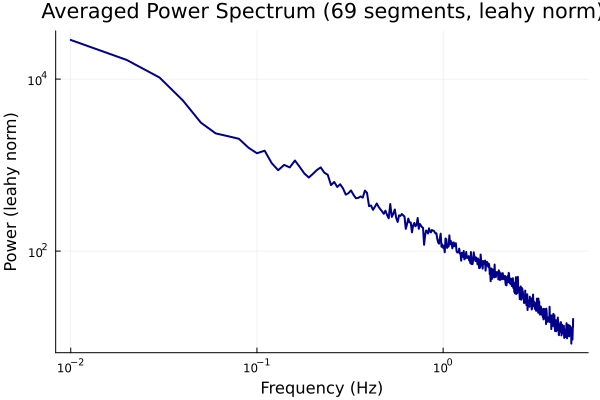

In [14]:
plot(avg_ps,plot_errors=false,frequency_unit="Hz")

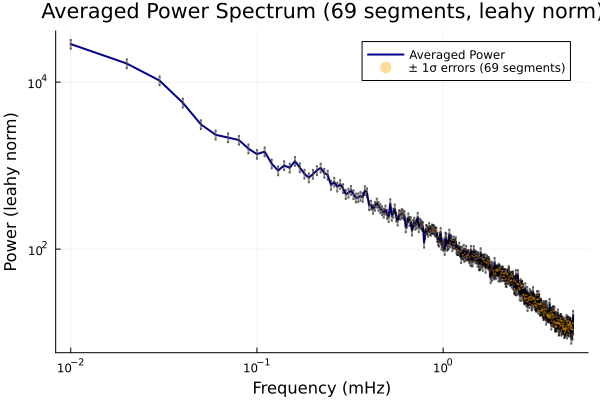

In [18]:
plot(avg_ps, plot_errors=true, frequency_unit="mHz")